In [727]:
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [728]:
df = pd.read_csv('../Datasets/Federal_Reserve_Economic_Database_Sale_Of_Bevrages/Federal _Reserve_Economic_Database_Sale_Of_Bevrages.csv',  index_col=0,parse_dates=True)
# need index column to take the dates as they are and not convert to integer where first day/month/year is given 0 and so one.

In [729]:
print(df.head())
print(df.info())
print(df.isnull().sum())

            S4248SM144NCEN
DATE                      
1992-01-01            3459
1992-02-01            3458
1992-03-01            4002
1992-04-01            4564
1992-05-01            4221
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 355 entries, 1992-01-01 to 2021-07-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   S4248SM144NCEN  355 non-null    int64
dtypes: int64(1)
memory usage: 5.5 KB
None
S4248SM144NCEN    0
dtype: int64


In [730]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = df['S4248SM144NCEN'].values
train = scaler.fit_transform(train.reshape(-1, 1))
train = torch.FloatTensor(train).view(-1)

In [731]:
train_temp = []
window = 10
for i in range(len(train)-window):
    train_temp.append((train[i:i+window],train[i+window:i+window+1]))
train = train_temp

In [732]:
class LSTM_model(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.hidden = (torch.zeros(1,1,self.hidden_size),torch.zeros(1,1,self.hidden_size))
        self.lstm = nn.LSTM(input_size,hidden_size)
        self.out = nn.Linear(hidden_size,output_size)

    def forward(self,x):
        self.hidden = (torch.zeros(1,1,self.hidden_size),torch.zeros(1,1,self.hidden_size))
        lstm_out, self.hidden = self.lstm(x.view(len(x),1,-1), self.hidden)
        pred = self.out(lstm_out.view(len(x),-1))
        return pred[-1]

In [733]:
torch.manual_seed(12345)
model = LSTM_model()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [734]:
preds = []
epochs = 20
for i in range(epochs):
    for x, y in train:
        optimizer.zero_grad()
        y_pred = model(x)
        if i+1 == epochs:
            preds.append(y.item())
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
    if i%10 == 0:
        print(f'Epoch: {i:2} Loss: {loss.item():10.8f}')

Epoch:  0 Loss: 0.35634667
Epoch: 10 Loss: 0.14784029


In [735]:
model.eval()
for i in range(40):
    x = torch.FloatTensor(preds[-window:])
    with torch.no_grad():
        preds.append(model(x).item())

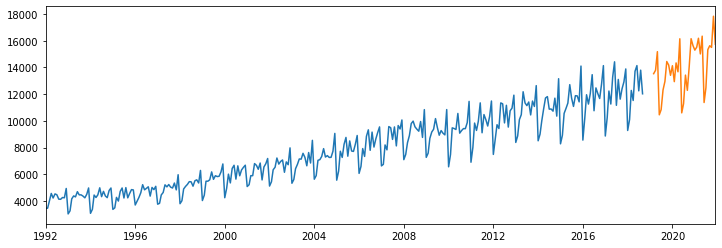

In [736]:
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
x = np.arange('2019-03-01', '2022-01-01', dtype='datetime64[M]').astype('datetime64[D]')
plt.figure(figsize=(12,4))
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'][:-(window+24)])
plt.plot(x,true_predictions[-(window+24+40):-40])
plt.show()